In [1]:
from darts.models import Theta, ARIMA, ExponentialSmoothing
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, ModelMode


from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import set_config
set_config(transform_output = "default")

from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor




from multiprocessing import Pool
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import missingno as msno
from plotly.colors import DEFAULT_PLOTLY_COLORS as colors


from utils import get_idle_proportion, add_time_tag, get_jobs_data
from constant import MAP_TIME_COL, NODE_TO_PARTITION_NAME

# from sklearn import set_config
# set_config(transform_output = "pandas")


# Classic ML and Econometric models training

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('/projects/2/prjs1098/system_analytics_2024/slurm_data')
folder_path_prom_data = Path('/projects/2/prjs1098/system_analytics_2024/prom_data')
folder_path_EAR_data = Path('/projects/2/prjs1098/system_analytics_2024/ear_data')
folder_path_saving_results = Path('./results')


# for getting the up-to-date data run the clenaing_sinfo file
# with the latest data from the system.
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_cleaned.parquet.gzip')


# this takes a bit of time, so we instead load the result
# df_prom_average = get_prom_average_node_sinfo(all_prom_file_paths[0:2], map_time_col[time_col], time_col)
df_prom_average = pd.read_parquet(folder_path_prom_data /'average_signal_prom'/'prom_average_data_Dec_13.parquet.gzip')

# job history
df_job_number_history = pd.read_parquet(folder_path_EAR_data / 'job_number_history_cleaned.parquet.gzip')
# get the latest tables from the EAR data base, this is not up to date
jobs_table_path = folder_path_EAR_data / 'jobs.parquet.gzip'
apps_table_path = folder_path_EAR_data / 'applications.parquet.gzip'
df_job_number_history_2 = get_jobs_data(jobs_table_path, apps_table_path)

display(df_job_number_history.head(), df_job_number_history_2.head())

step_id       app_id          start_time            end_time  \
0  4294967291  aiida-15733 2023-10-04 00:03:02 2023-10-04 06:57:26   
1           0  bt-mz.D.128 2024-01-30 12:58:48 2024-01-30 12:59:01   
2  4294967291  run_snel.sh 2024-03-21 12:46:28 2024-03-21 12:47:21   
3  4294967291  run_snel.sh 2024-03-21 12:46:28 2024-03-21 12:47:21   
4  4294967291  run_snel.sh 2024-03-21 12:46:28 2024-03-21 12:47:21   

  start_mpi_time end_mpi_time  job_id  node_id  signature_id  \
0     1970-01-01   1970-01-01       0  tcn1177     2184761.0   
1     1970-01-01   1970-01-01       1   tcn510           NaN   
2     1970-01-01   1970-01-01       1    fcn96           NaN   
3     1970-01-01   1970-01-01       1    fcn97           NaN   
4     1970-01-01   1970-01-01       1    tcn95           NaN   

   power_signature_id node_type  start_time_sec  end_time_sec  \
0             6870166       tcn      1696377782    1696402646   
1             8733020       tcn      1706619528    1706619541   
2             9904374       fcn      1711025188    1711025241   
3             9904373       fcn      1711025188    1711025241   
4            10188067       tcn      1711025188    1711025241   

   start_mpi_time_sec  end_mpi_time_sec      job_start_time  \
0                   0                 0 2023-10-04 00:03:02   
1                   0                 0 2024-01-30 12:58:48   
2                   0                 0 2024-01-30 12:58:48   
3                   0                 0 2024-01-30 12:58:48   
4                   0                 0 2024-01-30 12:58:48   

         job_end_time  job_start_time_hour  job_start_time_day  \
0 2023-10-04 06:57:26                    0                   4   
1 2024-03-21 12:47:21                   12                  30   
2 2024-03-21 12:47:21                   12                  30   
3 2024-03-21 12:47:21                   12                  30   
4 2024-03-21 12:47:21                   12                  30   

  job_start_time_date job_start_time_day_name  job_start_time_week  \
0          2023-10-04               Wednesday                   40   
1          2024-01-30                 Tuesday                    5   
2          2024-01-30                 Tuesday                    5   
3          2024-01-30                 Tuesday                    5   
4          2024-01-30                 Tuesday                    5   

   job_start_time_month job_start_time_year_quarter job_start_year_month  \
0                    10                      2023Q4              2023-10   
1                     1                      2024Q1              2024-01   
2                     1                      2024Q1              2024-01   
3                     1                      2024Q1              2024-01   
4                     1                      2024Q1              2024-01   

   job_start_time_year  start_hour  start_day start_time_date  \
0                 2023           0          4      2023-10-04   
1                 2024          12         30      2024-01-30   
2                 2024          12         21      2024-03-21   
3                 2024          12         21      2024-03-21   
4                 2024          12         21      2024-03-21   

  start_time_day_name  start_time_week  start_month start_quarter  \
0           Wednesday               40           10        2023Q4   
1             Tuesday                5            1        2024Q1   
2            Thursday               12            3        2024Q1   
3            Thursday               12            3        2024Q1   
4            Thursday               12            3        2024Q1   

  start_year_month  start_year  partition  
0          2023-10        2023  AMD_GENOA  
1          2024-01        2024   AMD_ROME  
2          2024-03        2024  fcn_nodes  
3          2024-03        2024  fcn_nodes  
4          2024-03        2024   AMD_ROME

step_id          start_time            end_time start_mpi_time  \
0           0 1970-01-01 00:00:00 2023-10-04 06:57:26     1970-01-01   
1  4294967291 2023-10-04 00:03:02 2023-10-04 06:57:26     1970-01-01   
2           0 2024-01-30 12:58:48 2024-01-30 12:59:01     1970-01-01   
3  4294967291 2024-03-21 12:46:28 2024-03-21 12:47:21     1970-01-01   
4  4294967291 2024-03-21 12:46:28 2024-03-21 12:47:21     1970-01-01   

  end_mpi_time  job_id  node_id  signature_id  power_signature_id  \
0   1970-01-01       0              2184771.0             6870176   
1   1970-01-01       0  tcn1177     2184761.0             6870166   
2   1970-01-01       1   tcn510           NaN             8733020   
3   1970-01-01       1    fcn96           NaN             9904374   
4   1970-01-01       1    fcn97           NaN             9904373   

       job_start_time        job_end_time job_start_time_date  
0 1970-01-01 00:00:00 2023-10-04 06:57:26          1970-01-01  
1 1970-01-01 00:00:00 2023-10-04 06:57:26          1970-01-01  
2 2024-01-30 12:58:48 2024-03-21 12:47:21          2024-01-30  
3 2024-01-30 12:58:48 2024-03-21 12:47:21          2024-01-30  
4 2024-01-30 12:58:48 2024-03-21 12:47:21          2024-01-30

In [3]:
# remove the latest date from sinfo to align with promehtues

df = add_time_tag(df)
# display a sample
N = len(df)//20
display(df.iloc[N: N + 5, :])

node                time      state node_type time_30min_interval  \
5  fcn6 2024-12-12 20:47:16  allocated       fcn 2024-12-12 20:30:00   
5  fcn6 2024-12-12 20:48:22  allocated       fcn 2024-12-12 20:30:00   
5  fcn6 2024-12-12 20:50:16  allocated       fcn 2024-12-12 20:30:00   
5  fcn6 2024-12-12 20:50:22  allocated       fcn 2024-12-12 20:30:00   
5  fcn6 2024-12-12 20:51:22  allocated       fcn 2024-12-12 20:30:00   

  time_1hour_interval time_2hour_interval time_3hour_interval  \
5 2024-12-12 20:00:00 2024-12-12 20:00:00 2024-12-12 18:00:00   
5 2024-12-12 20:00:00 2024-12-12 20:00:00 2024-12-12 18:00:00   
5 2024-12-12 20:00:00 2024-12-12 20:00:00 2024-12-12 18:00:00   
5 2024-12-12 20:00:00 2024-12-12 20:00:00 2024-12-12 18:00:00   
5 2024-12-12 20:00:00 2024-12-12 20:00:00 2024-12-12 18:00:00   

  time_4hour_interval time_6hour_interval time_12hour_interval  \
5 2024-12-12 20:00:00 2024-12-12 18:00:00  2024-12-12 12:00:00   
5 2024-12-12 20:00:00 2024-12-12 18:00:00  2024-12-12 12:00:00   
5 2024-12-12 20:00:00 2024-12-12 18:00:00  2024-12-12 12:00:00   
5 2024-12-12 20:00:00 2024-12-12 18:00:00  2024-12-12 12:00:00   
5 2024-12-12 20:00:00 2024-12-12 18:00:00  2024-12-12 12:00:00   

  time_day_interval     time_week_interval  
5        2024-12-12  2024-12-09/2024-12-15  
5        2024-12-12  2024-12-09/2024-12-15  
5        2024-12-12  2024-12-09/2024-12-15  
5        2024-12-12  2024-12-09/2024-12-15  
5        2024-12-12  2024-12-09/2024-12-15

In [4]:
"""    
PICK THE TIME INTERVAL THAT WE WANT TO GROUP DATA.
"""

# WHICH TIME INTEVAL MAKES SENSE FOR ML?
time_col = 'time_4hour_interval'

df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# show a smaple
initial_data_size= len(df_stat)
display(df_stat.sample(n=5))
print(f"initial data size: {initial_data_size}")
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")

# note the trick here! this happens again in the future for Promethues data
df_last = df.groupby(['node', time_col], as_index=False)[['node', time_col, 'state', 'time']].tail(1).copy()
# merge it with the main
df_stat = pd.merge(df_stat, df_last[['node', time_col, 'state', 'time']],
                   how='left', on=['node', time_col]).copy()
# rename it
df_stat.rename(columns={'time':'time_for_last_state', 'state': 'last_state'}, inplace=True)
# show a sample
display(df_stat.sample(n=10))
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")

df_stat.sort_values(['node', time_col], inplace=True)
# drop some columns
df_stat.drop(['idle_duration', 'all_state_durations_in_interval'],
             axis=1, inplace=True)
df_stat.head()

node time_4hour_interval   idle_duration  \
11122    fcn29 2024-11-24 08:00:00 0 days 03:58:34   
68868    gcn88 2024-11-10 00:00:00 0 days 00:00:00   
327016  tcn738 2024-11-23 00:00:00 0 days 03:58:28   
391707  tcn960 2024-11-19 04:00:00 0 days 03:58:33   
268880  tcn538 2024-11-27 16:00:00 0 days 00:00:00   

       all_state_durations_in_interval  idle_proportion  
11122                  0 days 03:58:34              1.0  
68868                  0 days 03:59:11              0.0  
327016                 0 days 03:58:28              1.0  
391707                 0 days 03:58:33              1.0  
268880                 0 days 03:59:06              0.0

initial data size: 402886
Is there duplication in node and time: False


node time_4hour_interval   idle_duration  \
344029  tcn797 2024-11-20 04:00:00 0 days 00:00:00   
49826     gcn2 2024-11-12 08:00:00 0 days 00:00:00   
227631  tcn396 2024-11-08 12:00:00 0 days 00:00:00   
66129    gcn78 2024-12-03 20:00:00 0 days 00:00:00   
355806  tcn837 2024-11-18 00:00:00 0 days 03:58:27   
235038  tcn420 2024-11-20 08:00:00 0 days 00:00:00   
294607  tcn626 2024-12-06 04:00:00 0 days 00:00:00   
191351   tcn27 2024-12-01 12:00:00 0 days 00:00:00   
286412  tcn599 2024-11-24 00:00:00 0 days 00:00:00   
387215  tcn945 2024-11-12 20:00:00 0 days 00:00:00   

       all_state_durations_in_interval  idle_proportion last_state  \
344029                 0 days 03:58:58              0.0      mixed   
49826                  0 days 03:59:19              0.0  allocated   
227631                 0 days 03:59:31              0.0  allocated   
66129                  0 days 03:59:05              0.0   reserved   
355806                 0 days 03:58:27              1.0       idle   
235038                 0 days 03:58:33              0.0  allocated   
294607                 0 days 03:59:52              0.0      mixed   
191351                 0 days 03:59:07              0.0  allocated   
286412                 0 days 03:58:37              0.0  allocated   
387215                 0 days 03:59:57              0.0  allocated   

       time_for_last_state  
344029 2024-11-20 07:59:41  
49826  2024-11-12 11:59:41  
227631 2024-11-08 15:59:58  
66129  2024-12-03 23:59:44  
355806 2024-11-18 03:58:41  
235038 2024-11-20 11:59:21  
294607 2024-12-06 07:59:59  
191351 2024-12-01 15:59:57  
286412 2024-11-24 03:59:46  
387215 2024-11-12 23:59:57

Is there duplication in node and time: False


node time_4hour_interval  idle_proportion last_state time_for_last_state
0  fcn1 2024-11-04 16:00:00              0.0      mixed 2024-11-04 19:59:37
1  fcn1 2024-11-04 20:00:00              0.0      mixed 2024-11-04 23:59:43
2  fcn1 2024-11-05 00:00:00              0.0      mixed 2024-11-05 03:59:33
3  fcn1 2024-11-05 04:00:00              0.0      mixed 2024-11-05 07:59:32
4  fcn1 2024-11-05 08:00:00              0.0      mixed 2024-11-05 11:59:33

Top 5 nodes with nan values: 
      node
gcn25     35
gcn56     35
tcn542     0
tcn541     0
tcn540     0
dtype: int64


<Axes: >

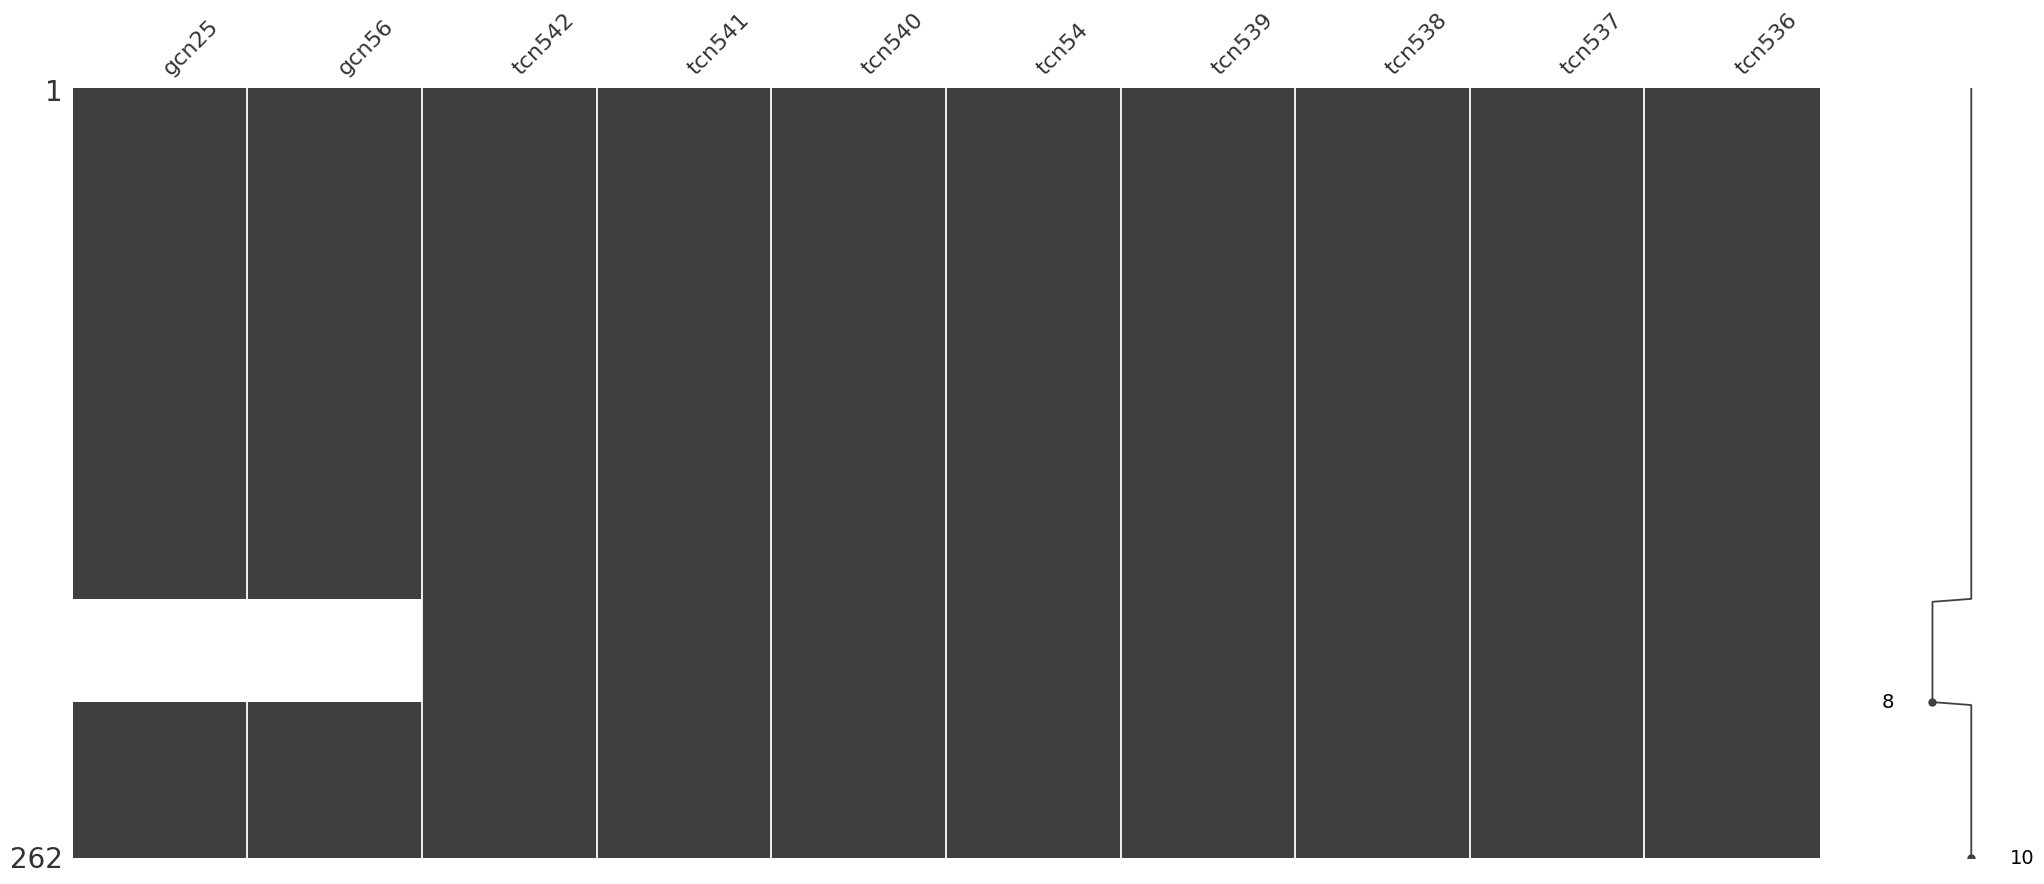

In [5]:
# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
# df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d")

print(f"""Top 5 nodes with nan values: 
      {df_stat_pivot.isna().sum().sort_values(ascending=False).head()}""")
node_names_with_high_nan_values = df_stat_pivot.isna().sum().sort_values(ascending=False).index.to_list()
df_sorted_nodes = df_stat_pivot[node_names_with_high_nan_values].copy()
msno.matrix(df_sorted_nodes.iloc[:, 0:10])

# we have nan values in the idle proportion!==> it seems that this has happened recently and two of the nodes are not
# showing any state values

In [6]:
"""  
Drop the nodes that have really bad nan values
"""
mask = (df_stat['node'] == 'gcn56') | (df_stat['node'] == 'gcn25')
df_stat = df_stat[~mask].copy()

# Feature engineering


Add new features to the data


In [7]:
# add the lags here; 
time_sample_in_one_day = pd.Timedelta('1day') // MAP_TIME_COL[time_col]

lags = (
    (np.arange(3) + 1).tolist()
    + (np.arange(3) + (time_sample_in_one_day-2)).tolist()
    + (np.arange(3) + (time_sample_in_one_day * 7) - 2).tolist()
)

for i in lags:
    df_stat[f'lag_{i}'] = df_stat.groupby('node', as_index=False)['idle_proportion'].shift(i)
    

# adding aggreation to the signals
rolls = [3 * time_sample_in_one_day, 2 * time_sample_in_one_day,  time_sample_in_one_day]
agg_functions = ['mean', 'std']

for agg_function in agg_functions:
    for roll in rolls:
        df_stat[f'roll_{roll}_{agg_function}'] = (df_stat
                                                  .groupby('node', as_index=False)['idle_proportion']
                                                  .shift(1) # shift to avoid leakage!
                                                  .rolling(roll)
                                                  .agg(agg_function))

# add calender feature like day of the week and month
df_stat['hour_day'] = df_stat[time_col].dt.hour
df_stat['week_day'] = df_stat[time_col].dt.day_of_week
# df_stat['month'] = df_stat[time_col].dt.month


# add parition name, use the map from constant
df_stat['partition'] = (df_stat['node']
                        .apply(lambda x: NODE_TO_PARTITION_NAME
                               .get(x, 'other')))

# shifting the last state to avoid data leakage.
df_stat['last_state_lag_1'] = (df_stat
                               .groupby('node', as_index=False)['last_state']
                               .shift(1))
# display some rows   
N = np.random.randint(len(df_stat) - 10)
df_stat.iloc[N:N+10, :]

node time_4hour_interval  idle_proportion last_state  \
204277  tcn314 2024-12-16 04:00:00           0.0000  allocated   
204278  tcn314 2024-12-16 08:00:00           0.0336    planned   
204279  tcn314 2024-12-16 12:00:00           0.0632       idle   
204280  tcn314 2024-12-16 16:00:00           0.1255       idle   
204281  tcn314 2024-12-16 20:00:00           0.3809    planned   
204282  tcn314 2024-12-17 00:00:00           0.0443    planned   
204283  tcn314 2024-12-17 04:00:00           0.0000    planned   
204284  tcn314 2024-12-17 08:00:00           0.0000  allocated   
204285  tcn314 2024-12-17 12:00:00           0.0000  allocated   
204286  tcn314 2024-12-17 16:00:00           0.0000  allocated   

       time_for_last_state   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6  \
204277 2024-12-16 07:59:45  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
204278 2024-12-16 11:59:34  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
204279 2024-12-16 15:59:42  0.0336  0.0000  0.0000  0.0000  0.0000  0.0000   
204280 2024-12-16 19:59:50  0.0632  0.0336  0.0000  0.0000  0.0000  0.0000   
204281 2024-12-16 23:59:57  0.1255  0.0632  0.0336  0.0000  0.0000  0.0000   
204282 2024-12-17 03:59:42  0.3809  0.1255  0.0632  0.0336  0.0000  0.0000   
204283 2024-12-17 07:58:34  0.0443  0.3809  0.1255  0.0632  0.0336  0.0000   
204284 2024-12-17 11:58:40  0.0000  0.0443  0.3809  0.1255  0.0632  0.0336   
204285 2024-12-17 15:58:50  0.0000  0.0000  0.0443  0.3809  0.1255  0.0632   
204286 2024-12-17 19:59:54  0.0000  0.0000  0.0000  0.0443  0.3809  0.1255   

        lag_40  lag_41  lag_42  roll_18_mean  roll_12_mean  roll_6_mean  \
204277  0.0587  0.0000  0.0000        0.0017        0.0000       0.0000   
204278  0.0000  0.0587  0.0000        0.0017        0.0000       0.0000   
204279  0.0000  0.0000  0.0587        0.0035        0.0028       0.0056   
204280  0.0759  0.0000  0.0000        0.0070        0.0081       0.0161   
204281  0.3985  0.0759  0.0000        0.0140        0.0185       0.0370   
204282  0.3798  0.3985  0.0759        0.0335        0.0503       0.1005   
204283  0.2936  0.3798  0.3985        0.0360        0.0540       0.1079   
204284  0.0000  0.2936  0.3798        0.0360        0.0540       0.1079   
204285  0.0000  0.0000  0.2936        0.0360        0.0540       0.1023   
204286  0.0000  0.0000  0.0000        0.0360        0.0540       0.0918   

        roll_18_std  roll_12_std  roll_6_std  hour_day  week_day partition  \
204277       0.0071       0.0000      0.0000         4         0  AMD_ROME   
204278       0.0071       0.0000      0.0000         8         0  AMD_ROME   
204279       0.0103       0.0097      0.0137        12         0  AMD_ROME   
204280       0.0174       0.0199      0.0267        16         0  AMD_ROME   
204281       0.0328       0.0390      0.0503        20         0  AMD_ROME   
204282       0.0926       0.1110      0.1451         0         1  AMD_ROME   
204283       0.0922       0.1099      0.1400         4         1  AMD_ROME   
204284       0.0922       0.1099      0.1400         8         1  AMD_ROME   
204285       0.0922       0.1099      0.1442        12         1  AMD_ROME   
204286       0.0922       0.1099      0.1498        16         1  AMD_ROME   

       last_state_lag_1  
204277        allocated  
204278        allocated  
204279          planned  
204280             idle  
204281             idle  
204282          planned  
204283          planned  
204284          planned  
204285        allocated  
204286        allocated

In [8]:
"""   
We biring the data about the number of jobs that happend before at the same day
last year or last quarter ...
"""

df_temp = df_job_number_history.groupby(['job_start_time_date'], as_index=False)['job_id'].aggregate(['nunique'])
df_temp['job_start_time_date'] = pd.to_datetime(df_temp['job_start_time_date'])
df_temp.rename(columns={'nunique': 'number_of_jobs'}, inplace=True)


# add this tag to do a merge
df_stat['date'] = pd.to_datetime(df_stat[time_col].dt.date)
df_stat['shift_date_one_year'] = pd.to_datetime((df_stat['date']  -  pd.DateOffset(years=1)))
df_stat['shift_date_two_year'] = pd.to_datetime(df_stat['date']  -  pd.DateOffset(years=2))
df_stat['shift_date_one_day'] = pd.to_datetime((df_stat['date']  -  pd.Timedelta('1day')))
df_stat['shift_date_one_week'] = pd.to_datetime(df_stat['date']  -  pd.Timedelta('7day'))
df_stat['shift_date_two_week'] = pd.to_datetime(df_stat['date']  -  pd.Timedelta('14day'))






map_shift_data_job= {'shift_date_one_year': 'number_of_jobs_1_year_ago',
 'shift_date_two_year': 'number_of_jobs_2_year_ago',
 'shift_date_one_day': 'number_of_jobs_1_day_ago',
 'shift_date_one_week': 'number_of_jobs_7_day_ago',
 'shift_date_two_week': 'number_of_jobs_14_day_ago',
 }




for key, val in map_shift_data_job.items():
    df_stat = df_stat.merge(df_temp, 
                        how='left', 
                        left_on=key, 
                        right_on='job_start_time_date')
    df_stat.rename(columns={'number_of_jobs': val}, inplace=True)
    df_stat.drop('job_start_time_date', axis=1, inplace=True)

display(df_stat.sample(n=5))

node time_4hour_interval  idle_proportion last_state  \
8862     fcn20 2024-12-10 16:00:00              1.0       idle   
4895    fcn115 2024-12-04 12:00:00              1.0       idle   
259401  tcn506 2024-11-08 04:00:00              0.0  allocated   
371800  tcn894 2024-11-08 08:00:00              1.0       idle   
194648  tcn282 2024-12-15 08:00:00              1.0       idle   

       time_for_last_state   lag_1   lag_2   lag_3   lag_4   lag_5  lag_6  \
8862   2024-12-10 19:59:22  1.0000  1.0000  1.0000  1.0000  1.0000  0.931   
4895   2024-12-04 15:59:05  1.0000  1.0000  1.0000  1.0000  1.0000  1.000   
259401 2024-11-08 07:59:36  0.0000  0.0000  0.0000  0.0000  0.0000  0.000   
371800 2024-11-08 11:59:57  1.0000  1.0000  1.0000  0.9971  1.0000  1.000   
194648 2024-12-15 11:58:58  0.6409  0.8238  0.8697  1.0000  0.9985  1.000   

        lag_40  lag_41  lag_42  roll_18_mean  roll_12_mean  roll_6_mean  \
8862       1.0     1.0  0.5897        0.9962        0.9943       0.9885   
4895       1.0     1.0  1.0000        1.0000        1.0000       1.0000   
259401     NaN     NaN     NaN        0.0006        0.0000       0.0000   
371800     NaN     NaN     NaN        0.6631        0.8502       0.9995   
194648     0.0     0.0  0.0000        0.5836        0.8366       0.8888   

        roll_18_std  roll_12_std  roll_6_std  hour_day  week_day  partition  \
8862         0.0163       0.0199      0.0282        16         1  fcn_nodes   
4895         0.0000       0.0000      0.0000        12         2  fcn_nodes   
259401       0.0025       0.0000      0.0000         4         4   AMD_ROME   
371800       0.3595       0.2073      0.0012         8         4  AMD_GENOA   
194648       0.4288       0.2412      0.1434         8         6   AMD_ROME   

       last_state_lag_1       date shift_date_one_year shift_date_two_year  \
8862               idle 2024-12-10          2023-12-10          2022-12-10   
4895               idle 2024-12-04          2023-12-04          2022-12-04   
259401        allocated 2024-11-08          2023-11-08          2022-11-08   
371800             idle 2024-11-08          2023-11-08          2022-11-08   
194648             idle 2024-12-15          2023-12-15          2022-12-15   

       shift_date_one_day shift_date_one_week shift_date_two_week  \
8862           2024-12-09          2024-12-03          2024-11-26   
4895           2024-12-03          2024-11-27          2024-11-20   
259401         2024-11-07          2024-11-01          2024-10-25   
371800         2024-11-07          2024-11-01          2024-10-25   
194648         2024-12-14          2024-12-08          2024-12-01   

        number_of_jobs_1_year_ago  number_of_jobs_2_year_ago  \
8862                         3056                     3178.0   
4895                         5068                     1566.0   
259401                       8928                        NaN   
371800                       8928                        NaN   
194648                       4693                     3359.0   

        number_of_jobs_1_day_ago  number_of_jobs_7_day_ago  \
8862                     12715.0                     17804   
4895                     17804.0                     21031   
259401                   11570.0                      8307   
371800                   11570.0                      8307   
194648                       NaN                      4387   

        number_of_jobs_14_day_ago  
8862                        14500  
4895                        11910  
259401                       8529  
371800                       8529  
194648                       8578

In [9]:
""" 
ENRICHING THE DATA SET:
Bring Promethues data set and get average of the measurement for the signals 
This possibly shows that when the node is not idle to which extent it was working.
"""

prom_selected_signals = [
'node_cpu_frequency_hertz_mean', 'node_filesystem_files_mean',
'node_cpu_frequency_max_hertz_mean',
 'node_cpu_frequency_min_hertz_mean',
 'node_cpu_package_throttles_total_mean',
 'node_disk_io_now_mean',
 'node_disk_read_bytes_total_mean',
 'node_disk_writes_completed_total_mean',
 'node_disk_written_bytes_total_mean',
 'node_filesystem_avail_bytes_mean',
 'node_filesystem_files_free_mean',
 'node_filesystem_free_bytes_mean',
  'node_network_receive_bytes_total_mean',
 'node_network_receive_drop_total_mean',
 'node_network_receive_multicast_total_mean',
 'node_network_receive_packets_total_mean',
 'node_network_transmit_bytes_total_mean',
 'node_network_transmit_packets_total_mean',
  'node_procs_blocked_mean',
 'node_procs_running_mean',
 'node_rapl_core_joules_total_mean',
 'node_rapl_dram_joules_total_mean',
 'node_rapl_package_joules_total_mean',
 'surf_ambient_temp_mean',
 'surf_confluent_mean',
 'surf_cpu_power_mean',
 'surf_exhaust_temp_mean',
 'surf_gpu_board_power_mean',
 'surf_inlet_water_temp_mean',
 'surf_mem_power_mean',
 'surf_sys_power_mean',
 'surf_temp_cpu_mean',
 'surf_virtual_mean',
 'up_mean']




df_prom_average[time_col] = (df_prom_average['time']).dt.floor(freq=MAP_TIME_COL[time_col])
# then do an average to get the result that you want
df_prom_average_interval = (df_prom_average.groupby(['node', time_col], as_index=False)
                                            .mean(numeric_only=True).copy())
display(df_prom_average_interval[prom_selected_signals].head())

print(f"Is there duplication in node and time: {df_prom_average_interval[['node', time_col]].duplicated().any()}")


#### do the merge finally here!
# add dummy time to prevent leakage
df_stat['shift_time_col'] = df_stat[time_col] - MAP_TIME_COL[time_col]
df_stat = pd.merge(df_stat, df_prom_average_interval[['node', time_col] + prom_selected_signals],
                   how='left', left_on=['node', 'shift_time_col'], right_on=['node', time_col],
                   suffixes=['', '_y']).copy()
display(df_stat.sample(n=5))
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")



node_cpu_frequency_hertz_mean  node_filesystem_files_mean  \
0                     2.6000e+09                  7.6521e+07   
1                     2.6000e+09                  7.6521e+07   
2                     2.6000e+09                  7.6778e+07   
3                     2.6000e+09                  7.6521e+07   
4                     2.6000e+09                  7.7179e+07   

   node_cpu_frequency_max_hertz_mean  node_cpu_frequency_min_hertz_mean  \
0                         2.6000e+09                         1.5000e+09   
1                         2.6000e+09                         1.5000e+09   
2                         2.6000e+09                         1.5000e+09   
3                         2.6000e+09                         1.5000e+09   
4                         2.6000e+09                         1.5000e+09   

   node_cpu_package_throttles_total_mean  node_disk_io_now_mean  \
0                                    NaN                    0.0   
1                                    NaN                    0.0   
2                                    NaN                    0.0   
3                                    NaN                    0.0   
4                                    NaN                    0.0   

   node_disk_read_bytes_total_mean  node_disk_writes_completed_total_mean  \
0                       4.8787e+08                            174514.9818   
1                       4.9235e+08                            180035.7026   
2                       4.9698e+08                            185777.1724   
3                       5.0182e+08                            191660.1031   
4                       5.0660e+08                            197445.7125   

   node_disk_written_bytes_total_mean  node_filesystem_avail_bytes_mean  \
0                          4.3066e+09                        3.1292e+11   
1                          4.4342e+09                        3.1292e+11   
2                          4.5646e+09                        3.1396e+11   
3                          4.7003e+09                        3.1292e+11   
4                          4.8432e+09                        3.1558e+11   

   node_filesystem_files_free_mean  node_filesystem_free_bytes_mean  \
0                       7.6521e+07                       3.1292e+11   
1                       7.6521e+07                       3.1292e+11   
2                       7.6778e+07                       3.1396e+11   
3                       7.6521e+07                       3.1292e+11   
4                       7.7179e+07                       3.1558e+11   

   node_network_receive_bytes_total_mean  \
0                             2.5400e+09   
1                             2.6217e+09   
2                             2.7039e+09   
3                             2.7860e+09   
4                             2.8687e+09   

   node_network_receive_drop_total_mean  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   node_network_receive_multicast_total_mean  \
0                                 4.2268e+06   
1                                 4.3799e+06   
2                                 4.5292e+06   
3                                 4.6681e+06   
4                                 4.8020e+06   

   node_network_receive_packets_total_mean  \
0                               9.2658e+06   
1                               9.5981e+06   
2                               9.9240e+06   
3                               1.0236e+07   
4                               1.0537e+07   

   node_network_transmit_bytes_total_mean  \
0                              3.8131e+08   
1                              3.9006e+08   
2                              3.9956e+08   
3                              4.0997e+08   
4                              4.1990e+08   

   node_network_transmit_packets_total_mean  node_procs_blocke

Is there duplication in node and time: False


node time_4hour_interval  idle_proportion last_state  \
150914  tcn131 2024-11-05 00:00:00              0.0  allocated   
396733   tcn98 2024-11-15 12:00:00              0.0  allocated   
399667   tcn99 2024-11-24 04:00:00              1.0       idle   
396042  tcn977 2024-12-01 08:00:00              1.0       idle   
244602  tcn455 2024-11-30 16:00:00              0.0  allocated   

       time_for_last_state  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_40  \
150914 2024-11-05 03:59:33    0.0    0.0    NaN    NaN    NaN    NaN     NaN   
396733 2024-11-15 15:59:49    0.0    0.0    0.0    0.0    0.0    0.0     0.0   
399667 2024-11-24 07:59:54    1.0    1.0    1.0    1.0    1.0    1.0     0.0   
396042 2024-12-01 11:59:41    1.0    1.0    1.0    1.0    1.0    1.0     1.0   
244602 2024-11-30 19:59:17    0.0    0.0    0.0    0.0    0.0    0.0     1.0   

        lag_41  lag_42  roll_18_mean  roll_12_mean  roll_6_mean  roll_18_std  \
150914     NaN     NaN           NaN           NaN          NaN          NaN   
396733     0.0     0.0        0.0000        0.0000          0.0       0.0000   
399667     0.0     0.0        0.5599        0.8399          1.0       0.4931   
396042     1.0     1.0        0.9962        1.0000          1.0       0.0163   
244602     1.0     1.0        0.4397        0.4331          0.0       0.4693   

        roll_12_std  roll_6_std  hour_day  week_day  partition  \
150914          NaN         NaN         0         1   AMD_ROME   
396733       0.0000         0.0        12         4   AMD_ROME   
399667       0.3454         0.0         4         6   AMD_ROME   
396042       0.0000         0.0         8         6  AMD_GENOA   
244602       0.4824         0.0        16         5   AMD_ROME   

       last_state_lag_1       date shift_date_one_year shift_date_two_year  \
150914        allocated 2024-11-05          2023-11-05          2022-11-05   
396733        allocated 2024-11-15          2023-11-15          2022-11-15   
399667             idle 2024-11-24          2023-11-24          2022-11-24   
396042             idle 2024-12-01          2023-12-01          2022-12-01   
244602        allocated 2024-11-30          2023-11-30          2022-11-30   

       shift_date_one_day shift_date_one_week shift_date_two_week  \
150914         2024-11-04          2024-10-29          2024-10-22   
396733         2024-11-14          2024-11-08          2024-11-01   
399667         2024-11-23          2024-11-17          2024-11-10   
396042         2024-11-30          2024-11-24          2024-11-17   
244602         2024-11-29          2024-11-23          2024-11-16   

        number_of_jobs_1_year_ago  number_of_jobs_2_year_ago  \
150914                       9675                        NaN   
396733                       6624                     2919.0   
399667                       7433                     4416.0   
396042                      10871                     2159.0   
244602                       7455                     3040.0   

        number_of_jobs_1_day_ago  number_of_jobs_7_day_ago  \
150914                   22253.0                     13339   
396733                   13226.0                     12129   
399667                    6678.0                      6225   
396042                   15217.0                      5891   
244602                   23349.0                      6678   

        number_of_jobs_14_day_ago      shift_time_col time_4hour_interval_y  \
150914                       9889 2024-11-04 20:00:00   2024-11-04 20:00:00   
396733                       8307 2024-11-15 08:00:00   2024-11-15 08:00:00   
399667                       8053 2024-11-24 00:00:00   2024-11-24 00:00:00   
396042                       6225 2024-12-01 04:00:00   2024-12-01 04:00:00   
244602                      10089 2024-11-30 12:00:00   2024-11-30 12:00:00   

        node_cpu_frequency_hertz_mean  node_filesystem_files_mean  \
150914                     2.6000e+09                  2.6600e+07   

Is there duplication in node and time: False


In [ ]:
"""   
Dropping all the columns that we think might not be useful.
"""

df_stat.drop((['date', 'shift_time_col', f"{time_col}_y"] 
              + list(map_shift_data_job.keys()) + ['last_state', 'time_for_last_state']),
             axis=1, inplace=True)


# rename idle_proportion to target
df_stat.rename(columns={'idle_proportion':'target'}, inplace=True)
# save the data here:
# df_stat.to_parquet(folder_path_slurm_data / 'sinfo_for_tabular_ML.parquet.gzip')

display(df_stat.sample(n=5))

node time_4hour_interval  target   lag_1   lag_2   lag_3  lag_4  \
313064   tcn691 2024-12-14 00:00:00     1.0  1.0000  0.9845  0.9305    1.0   
340741   tcn787 2024-11-28 04:00:00     1.0  0.4578  0.1422  0.0000    0.0   
258285   tcn501 2024-12-10 12:00:00     0.0  0.0000  0.0000  0.0000    0.0   
138032  tcn1223 2024-12-11 08:00:00     1.0  1.0000  1.0000  1.0000    1.0   
337492   tcn776 2024-11-10 16:00:00     0.0  0.0000  0.0000  0.0000    0.0   

        lag_5   lag_6  lag_40  lag_41  lag_42  roll_18_mean  roll_12_mean  \
313064    1.0  1.0000  0.0000   0.000  0.0000        0.9322        0.9929   
340741    0.0  0.0000  0.0894   0.628  0.1679        0.1466        0.0741   
258285    0.0  0.3115  0.0000   0.000  0.0000        0.1113        0.1670   
138032    1.0  1.0000  1.0000   1.000  1.0000        1.0000        1.0000   
337492    0.0  0.0000     NaN     NaN     NaN        0.0001        0.0002   

        roll_6_mean  roll_18_std  roll_12_std  roll_6_std  hour_day  week_day  \
313064       0.9858       0.1445       0.0201      0.0278         0         5   
340741       0.1000       0.2696       0.1501      0.1843         4         3   
258285       0.0519       0.2624       0.3103      0.1272        12         1   
138032       1.0000       0.0000       0.0000      0.0000         8         2   
337492       0.0000       0.0005       0.0006      0.0000        16         6   

        partition last_state_lag_1  number_of_jobs_1_year_ago  \
313064  AMD_GENOA             idle                       4722   
340741  AMD_GENOA             idle                       7863   
258285   AMD_ROME            mixed                       3056   
138032  AMD_GENOA             idle                       6069   
337492  AMD_GENOA        allocated                       7246   

        number_of_jobs_2_year_ago  number_of_jobs_1_day_ago  \
313064                     2462.0                       NaN   
340741                     2043.0                   21031.0   
258285                     3178.0                   12715.0   
138032                     2070.0                   17558.0   
337492                        NaN                    4134.0   

        number_of_jobs_7_day_ago  number_of_jobs_14_day_ago  \
313064                      4083                      15217   
340741                     12310                      13226   
258285                     17804                      14500   
138032                     21705                      21031   
337492                      6391                       4185   

        node_cpu_frequency_hertz_mean  node_filesystem_files_mean  \
313064                            NaN                         NaN   
340741                     2.4000e+09                  4.7001e+07   
258285                     2.6000e+09                  2.4635e+07   
138032                     2.4000e+09                  4.9831e+07   
337492                     2.4000e+09                  3.9798e+07   

        node_cpu_frequency_max_hertz_mean  node_cpu_frequency_min_hertz_mean  \
313064                                NaN                                NaN   
340741                         3.7078e+09                         1.5000e+09   
258285                         2.6000e+09                         1.5000e+09   
138032                         3.7078e+09                         1.5000e+09   
337492                         3.7078e+09                         1.5000e+09   

        node_cpu_package_throttles_total_mean  node_disk_io_now_mean  \
313064                                    NaN                    NaN   
340741                                    NaN                    0.0   
258285                                    NaN                    NaN   
138032                                    NaN                    0.0   
337492                                    NaN                    0.0   

        node_disk_read_bytes_total_mean  \
313064                              NaN   
340741                      

# Train Test Valildation Split


The final week in the data for test and the week before that is for validation


In [11]:
TEST_DATA_LENGTH = pd.Timedelta('7days')
VAL_DATA_LENGTH = pd.Timedelta('7days')

test_upper_bound = df_stat[time_col].max()
test_lower_bound = test_upper_bound - TEST_DATA_LENGTH

val_upper_bound = test_lower_bound - MAP_TIME_COL[time_col]
val_lower_bound = val_upper_bound - VAL_DATA_LENGTH


val_mask = (val_lower_bound<=df_stat[time_col]) & (df_stat[time_col]<=val_upper_bound)
test_mask = (test_lower_bound<=df_stat[time_col]) & (df_stat[time_col]<=test_upper_bound)
train = df_stat[~(val_mask|test_mask)]
val = df_stat[val_mask]
test = df_stat[test_mask]



X_train = train.iloc[:, 3:]
y_train = train.iloc[:,0:3]

X_val = val.iloc[:,3:]
y_val = val.iloc[:,0:3]

X_test = test.iloc[:,3:]
y_test = test.iloc[:,0:3]


print(f"""val lower bound:{val_lower_bound}, val upper bound:{val_upper_bound}, test lower bound:{test_lower_bound}, 
      test lower bound: {test_upper_bound}""")
print(f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}")
print(f"""Max Date in Train: {train[time_col].max()} | Min Date in Validation: {val[time_col].min()}|  Max Date in Validation: {val[time_col].max()}|
      Min Date in Test: {test[time_col].min()}| Max Date in Test: {test[time_col].max()}""")


val lower bound:2024-12-04 00:00:00, val upper bound:2024-12-11 00:00:00, test lower bound:2024-12-11 04:00:00, 
      test lower bound: 2024-12-18 04:00:00
# of Training samples: 270336 | # of Validation samples: 66048 | # of Test samples: 66048
Max Date in Train: 2024-12-03 20:00:00 | Min Date in Validation: 2024-12-04 00:00:00|  Max Date in Validation: 2024-12-11 00:00:00|
      Min Date in Test: 2024-12-11 04:00:00| Max Date in Test: 2024-12-18 04:00:00


In [12]:
""" preprocessing the data"""

categorical_column = ['hour_day', 'week_day','partition', 'last_state_lag_1']

transformer = make_column_transformer(
    # (RobustScaler(), prom_selected_signals),
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), categorical_column),
    # (SimpleImputer(strategy='constant', fill_value=0), 'all'),
    remainder='passthrough')


# transoform the data
X_train_trans = transformer.fit_transform(X_train)
X_val_trans = transformer.transform(X_val)
X_test_trans = transformer.transform(X_test)
print(X_train_trans.shape, X_val_trans.shape, X_test_trans.shape)



X_train_trans = pd.DataFrame(X_train_trans).fillna(0, inplace=False)
X_val_trans = pd.DataFrame(X_val_trans).fillna(0, inplace=False)
X_test_trans = pd.DataFrame(X_test_trans).fillna(0, inplace=False)


(270336, 92) (66048, 92) (66048, 92)


In [13]:
def perform_grid_search(model_class_with_params, X_train, y_train, X_val, y_val, target_column):

    # parameter_space = list(ParameterGrid(grid_params))
    model_class = model_class_with_params['model_class']
    del model_class_with_params['model_class']
    
        
    model = model_class(**model_class_with_params)
    print(model_class)
    model.fit(X_train, y_train[target_column])
    
    y_val_pred = model.predict(X_val)
    score = (mean_squared_error(y_val[target_column], y_val_pred))
    
    # grid_search_trials = pd.DataFrame({"params": parameter_space, "score": scores}).sort_values("score")
    # best_params = grid_search_trials.iloc[0, 0]
    # best_score = grid_search_trials.iloc[0, 1]

    return {'model_class': f"{str(model).split('(')[0]}", "parameter": model_class_with_params, "score": score}



def classic_eco_training(model, model_name, y_train, y_val, y_test):
    
    # pivot the table for plotting, call the function for getting longer intervals
    y_train_piv = pd.pivot_table(y_train[['node', time_col, 'target']],
                                 index=time_col, columns=['node'], values=['target'])
    y_train_piv = y_train_piv.droplevel(level=0, axis=1).copy()


    y_val_piv = pd.pivot_table(y_val[['node', time_col, 'target']],
                               index=time_col, columns=['node'], values=['target'])
    y_val_piv = y_val_piv.droplevel(level=0, axis=1).copy()

    y_test_piv = pd.pivot_table(y_test[['node', time_col, 'target']], 
                                index=time_col, columns=['node'], values=['target'])
    y_test_piv = y_test_piv.droplevel(level=0, axis=1).copy()

    # transform the data suitable for dart library
    train_series_for_validation = [TimeSeries.from_dataframe(y_train_piv, value_cols=col)
                                   for col in y_train_piv.columns]
    
    y_train_for_test = pd.concat([y_train_piv, y_val_piv], axis=0)
    train_series_for_test = [TimeSeries.from_dataframe(y_train_for_test, value_cols=col)
                                for col in y_train_for_test.columns]
    
    # val_series = [TimeSeries.from_dataframe(y_val_piv, value_cols=col) for col in y_val_piv.columns]
    # test_series = [TimeSeries.from_dataframe(y_test_piv, value_cols=col) for col in y_test_piv.columns]


    theta_val_pred = []
    theta_test_pred = []
    # train is df
    for series in (train_series_for_validation):
        # print(series.values())
        model.fit(series)
        pred = model.predict(len(y_val_piv))
        theta_val_pred.append(pred)
        

    for series in (train_series_for_test):
        # print(series.values())
        model.fit(series)
        pred = model.predict(len(y_test_piv))
        theta_test_pred.append(pred)
        
        
    df_theta_val_pred = pd.concat([pd.Series(p.values().flatten()) for p in theta_val_pred], axis=1) 
    df_theta_val_pred.index, df_theta_val_pred.columns = y_val_piv.index, y_val_piv.columns

    df_theta_test_pred = pd.concat([pd.Series(p.values().flatten()) for p in theta_test_pred], axis=1) 
    df_theta_test_pred.index, df_theta_test_pred.columns = y_test_piv.index, y_test_piv.columns



    df_theta_val_pred.reset_index(inplace=True)
    df_theta_val_pred = df_theta_val_pred.melt(id_vars=time_col)

    df_theta_test_pred.reset_index(inplace=True)
    df_theta_test_pred = df_theta_test_pred.melt(id_vars=time_col)

    y_val = y_val.merge(df_theta_val_pred, how='left', on=['node', time_col])
    y_test = y_test.merge(df_theta_test_pred, how='left', on=['node', time_col])
    y_val.rename(columns={'value':model_name}, inplace=True)
    y_test.rename(columns={'value':model_name}, inplace=True)
    return y_val, y_test


In [14]:
"""    
                            Naive one step ahead prediction, 

use the previous value as your prediction
Naive seasnoal prediction: get the value of previous week excatly the same time and say that this is my prediction
"""
y_train['label'] = 'train'
y_val['label'] = 'val'
y_test['label'] = 'test'

train_val_test_concat = pd.concat([y_train, y_val, y_test], axis=0)
train_val_test_concat.sort_values(['node', time_col], inplace=True)

train_val_test_concat['shifted_target'] = train_val_test_concat.groupby('node')['target'].shift(1)
train_val_test_concat['shifted_target_week'] = (train_val_test_concat
                                                .groupby('node')['target']
                                                .shift(time_sample_in_one_day * 7))


# the first model
y_test['Naive'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'test', 'shifted_target']
y_test['Naive seasonal'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'test', 'shifted_target_week']


# save this for later use and training a meta model
y_val['Naive'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'val', 'shifted_target']
y_val['Naive seasonal'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'val', 'shifted_target_week']

# drop the labels
y_train.drop(columns='label', inplace=True)
y_val.drop(columns='label', inplace=True)
y_test.drop(columns='label', inplace=True)


In [15]:
"""
                      *** Econometric  models ***
"""

# model = Theta(theta=2, season_mode=SeasonalityMode.ADDITIVE)
# y_val, y_test = classic_eco_training(model, 'Theta', y_train, y_val, y_test)

# model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE)
# y_val, y_test = classic_eco_training(model, 'Exponential', y_train, y_val, y_test)

# model = ARIMA(p=2, d=1, q =1)
# y_val, y_test = classic_eco_training(model, 'ARIMA', y_train, y_val, y_test)


'\n                      *** Econometric  models ***\n'

In [16]:
# """   
# Grid search for some hand picked ML classic models. 
# It takes time, go to the next cell, we load the results!!!
# """

param_grids = [
    {
        'model_class': [Lasso],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 10000]
    },
    {
        'model_class': [Ridge],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 10000]
    },
    
    {
        'model_class': [XGBRFRegressor],
        'n_estimators': [10, 50, 100, 200, 300, 400, 500],
        'colsample_bytree': [0.1, 0.5, 1],
        'device': ['gpu']
    },
    {
        'model_class': [XGBRegressor],
        'n_estimators': [10, 50, 100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        'device': ['gpu']
    },
    {
        'model_class': [LGBMRegressor],
        'n_estimators': [10, 50, 100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        # 'device': ['gpu']
    }
]



# Prepare the arguments for each model
model_args = [
    (model_class_with_params, X_train_trans, y_train, X_val_trans, y_val, 'target')
    for model_class_with_params in list(ParameterGrid(param_grids))
]

# # # Use a multiprocessing Pool with 3 workers
# if __name__ == "__main__":
#     with Pool(10) as pool:
#         all_models_score_with_paramerers = pool.starmap(perform_grid_search, model_args)


# simple for loop
all_models_score_with_paramerers = [perform_grid_search(*args) for args in model_args]


with open('all_models_best_params.pickle', 'wb') as handle:
    pickle.dump(all_models_score_with_paramerers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    

<class 'sklearn.linear_model._coordinate_descent.Lasso'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+03, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(


<class 'sklearn.linear_model._coordinate_descent.Lasso'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.777e+03, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(


<class 'sklearn.linear_model._coordinate_descent.Lasso'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.765e+03, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(


<class 'sklearn.linear_model._coordinate_descent.Lasso'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+04, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(


<class 'sklearn.linear_model._coordinate_descent.Lasso'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.283e+04, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(


<class 'sklearn.linear_model._coordinate_descent.Lasso'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e+04, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(


<class 'sklearn.linear_model._coordinate_descent.Lasso'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.444e+04, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(


<class 'sklearn.linear_model._ridge.Ridge'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.36125e-36): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.linear_model._ridge.Ridge'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.2843e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:42] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRFRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:11] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:11] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:16] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:18] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:18] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'xgboost.sklearn.XGBRegressor'>


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:59:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


<class 'lightgbm.sklearn.LGBMRegressor'>
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10990
[LightGBM] [Info] Number of data points in the train set: 270336, number of used features: 86
[LightGBM] [Info] Start training from score 0.419398
<class 'lightgbm.sklearn.LGBMRegressor'>
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10990
[LightGBM] [Info] Number of data points in the train set: 270336, number of used features: 86
[LightGBM] [Info] Start training from score 0.419398
<class 'lightgbm.sklearn.LGBMRegressor'>
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

In [17]:
with open('all_models_best_params.pickle', 'rb') as handle:
    all_models_score_with_paramerers = pickle.load(handle)
    
df_all_models_score_with_paramerers = pd.DataFrame(all_models_score_with_paramerers) 
df_model_score_best = (df_all_models_score_with_paramerers
                       .sort_values(by=['model_class', 'score'])
                       .groupby('model_class')
                       .head(1))
display(df_all_models_score_with_paramerers, df_model_score_best)
map_name_to_class = {'LGBMRegressor':LGBMRegressor,
                     'Lasso':Lasso,
                     'Ridge':Ridge,
                     'XGBRFRegressor':XGBRFRegressor,
                     'XGBRegressor':XGBRegressor
                     }

for i, model_spec in df_model_score_best.iterrows():
    best_model_name = model_spec['model_class']
    best_model_class = map_name_to_class[best_model_name]
    best_params = model_spec['parameter']
    
    # Initialize the model with the best parameters
    model = best_model_class(**best_params)

    # Train the model on the entire training data
    model.fit(X_train_trans, y_train['target'])
    # save this for later use fir fitting a model on top of this
    y_val[f"{str(model).split('(')[0]}"] = model.predict(X_val_trans)
    # do predition for the test data
    y_test[f"{str(model).split('(')[0]}"] = model.predict(X_test_trans)
    

model_class                                          parameter   score
0            Lasso                                  {'alpha': 0.0001}  0.0316
1            Lasso                                   {'alpha': 0.001}  0.0344
2            Lasso                                    {'alpha': 0.01}  0.0356
3            Lasso                                     {'alpha': 0.1}  0.1156
4            Lasso                                       {'alpha': 1}  0.1169
5            Lasso                                      {'alpha': 10}  0.1433
6            Lasso                                   {'alpha': 10000}  0.1800
7            Ridge                                  {'alpha': 0.0001}  0.0318
8            Ridge                                   {'alpha': 0.001}  0.0345
9            Ridge                                    {'alpha': 0.01}  0.0326
10           Ridge                                     {'alpha': 0.1}  0.0319
11           Ridge                                       {'alpha': 1}  0.0316
12           Ridge                                      {'alpha': 10}  0.0314
13           Ridge                                   {'alpha': 10000}  0.0380
14  XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'gpu', 'n_...  0.0413
15  XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'gpu', 'n_...  0.0424
16  XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'gpu', 'n_...  0.0452
17  XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'gpu', 'n_...  0.0411
18  XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'gpu', 'n_...  0.0415
19  XGBRFRegressor  {'colsample_bytree': 0.5, 'device': 'gpu', 'n_...  0.0270
20  XGBRFRegressor  {'colsample_bytree': 0.5, 'device': 'gpu', 'n_...  0.0268
21  XGBRFRegressor  {'colsample_bytree': 0.5, 'device': 'gpu', 'n_...  0.0266
22  XGBRFRegressor  {'colsample_bytree': 0.5, 'device': 'gpu', 'n_...  0.0266
23  XGBRFRegressor  {'colsample_bytree': 0.5, 'device': 'gpu', 'n_...  0.0265
24  XGBRFRegressor  {'colsample_bytree': 1, 'device': 'gpu', 'n_es...  0.0277
25  XGBRFRegressor  {'colsample_bytree': 1, 'device': 'gpu', 'n_es...  0.0274
26  XGBRFRegressor  {'colsample_bytree': 1, 'device': 'gpu', 'n_es...  0.0272
27  XGBRFRegressor  {'colsample_bytree': 1, 'device': 'gpu', 'n_es...  0.0270
28  XGBRFRegressor  {'colsample_bytree': 1, 'device': 'gpu', 'n_es...  0.0269
29    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.01, 'n_es...  0.1882
30    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.01, 'n_es...  0.1587
31    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.01, 'n_es...  0.1345
32    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.01, 'n_es...  0.0523
33    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.01, 'n_es...  0.0281
34    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.1, 'n_est...  0.0499
35    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.1, 'n_est...  0.0277
36    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.1, 'n_est...  0.0242
37    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.1, 'n_est...  0.0228
38    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.1, 'n_est...  0.0223
39    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.3, 'n_est...  0.0244
40    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.3, 'n_est...  0.0239
41    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.3, 'n_est...  0.0237
42    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.3, 'n_est...  0.0230
43    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.3, 'n_est...  0.0236
44    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.5, 'n_est...  0.0245
45    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.5, 'n_est...  0.0243
46    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.5, 'n_est...  0.0246
47    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.5, 'n_est...  0.0256
48    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.5, 'n_est...  0.0277
49   LGBMRegressor        {'learning_rate': 0.01, 'n_estimators': 10}  0.1881
50   LGBMRegressor        {'l

model_class                                          parameter   score
58   LGBMRegressor        {'learning_rate': 0.1, 'n_estimators': 200}  0.0221
0            Lasso                                  {'alpha': 0.0001}  0.0316
12           Ridge                                      {'alpha': 10}  0.0314
23  XGBRFRegressor  {'colsample_bytree': 0.5, 'device': 'gpu', 'n_...  0.0265
38    XGBRegressor  {'device': 'gpu', 'learning_rate': 0.1, 'n_est...  0.0223

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10990
[LightGBM] [Info] Number of data points in the train set: 270336, number of used features: 86
[LightGBM] [Info] Start training from score 0.419398


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e+03, tolerance: 6.009e+00
  model = cd_fast.enet_coordinate_descent(
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:04:31] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:04:31] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:04:42] WARNING: /worksp

In [18]:
"""    
simple Ensembling methods are presented here:
"""
model = Lasso()
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
reg = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)

reg.fit(X=y_val.iloc[:,3:], y=y_val['target'])


y_test[f"Linear Ensemble"] = reg.best_estimator_.predict(y_test.iloc[:,3:])

y_test.head()

node time_4hour_interval  target  Naive  Naive seasonal  LGBMRegressor  \
219  fcn1 2024-12-11 04:00:00  1.0000    1.0          1.0000         0.9897   
220  fcn1 2024-12-11 08:00:00  0.0000    1.0          0.0000         0.9191   
221  fcn1 2024-12-11 12:00:00  0.0000    0.0          0.0000         0.0852   
222  fcn1 2024-12-11 16:00:00  0.0000    0.0          0.0000         0.1173   
223  fcn1 2024-12-11 20:00:00  0.2443    0.0          0.0033         0.1693   

      Lasso   Ridge  XGBRFRegressor  XGBRegressor  Linear Ensemble  
219  1.0125  1.0144          0.9807        0.9996           0.9928  
220  0.9636  0.9603          0.9766        0.9331           0.9209  
221  0.1356  0.1255          0.1695        0.1117           0.0956  
222  0.1470  0.1386          0.1417        0.1106           0.1143  
223  0.0254  0.0231          0.1059        0.1624           0.1660

In [19]:
model_in_y_test = y_test.columns.to_list()[3:]
number_of_models = len(model_in_y_test)
y_true = np.tile(y_test['target'].values, (number_of_models, 1)).T  
# Extract y_pred (all columns starting from the 4th column)
y_pred = y_test.iloc[:, 3:].values

# Compute the mean squared error
mse = mean_squared_error(y_true=y_true, y_pred=y_pred, multioutput='raw_values')
mae = mean_squared_error(y_true=y_true, y_pred=y_pred, multioutput='raw_values')



df_performance = pd.DataFrame({'Algorithm':model_in_y_test,
             'MAE':mae,
             'MSE':mse})
metric_styled = df_performance.style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                        #   "MASE": "{:.3f}", 
                        #   "Forecast Bias": "{:.2f}%"}
                        }
                                           ).highlight_min(color='blue', subset=["MAE","MSE"])
display(metric_styled)

In [20]:
awful_model_to_not_show = ['Theta']
all_pred_df = pd.concat([y_val[['node', time_col, 'target']], y_test], axis=0)
all_pred_df.sort_values(['node', time_col], inplace=True)
all_node_names = all_pred_df['node'].unique()
random_nodes = np.random.choice(all_node_names, 4)
random_nodes
all_pred_df.head(n=6)


# Initialize subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=random_nodes)

# Loop through partitions
for i, node in enumerate(random_nodes):
    
    df_temp = all_pred_df[all_pred_df.node==node].iloc[:, 1:]
    df_temp.set_index(time_col, inplace=True)
    
    # display(df_temp.head())
    for j, model_name in enumerate(df_temp.columns):
        fig.add_trace( 
                        go.Scatter(
                                    y=df_temp[model_name].values,
                                    x=df_temp.index, name=model_name,
                                    # mode='lines+markers',
                                    line=dict(color=colors[j]), 
                                    # marker=dict(symbol=markers[j]),
                                    showlegend=(i == 0) 
                                    ), 
                        row=(i//2)+1, col=(i%2)+1)



fig.update_layout(
    title="Idle sample nodes and prediction",
    height=len(random_nodes) * 150  # Adjust height based on number of partitions
)

# Display the Plotly figure
fig.show()

In [21]:
"""   
                    From heat map to heat map!
                    
To give a better presentation we show the prediction error for each node at each time step in the Heatmap format.

dark red ==> absoute value for predition error is 0, abs(y_hat(t) - y(t)) = 0
white  ==> 1 absoute value for predition error is 1, abs(y_hat(t) - y(t)) = 1

"""



best_model_index = df_performance.idxmin()['MSE']
best_model = df_performance.iloc[best_model_index,0]
y_test['error'] = (y_test['target'] - y_test[best_model]).abs()
print(f"Keep an eye on this value: {y_test['error'].max()}, if it is larger than 1 the figure is not correct" )


# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(y_test, index=time_col, columns=['node'], values=['error'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H")
# df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d")


display(df_stat_pivot.head())

# plotting

# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]

titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]


map_time_column_names = {"time_30min_interval": "30 minutes interval",
                         "time_1hour_interval": "1 hour interval",
                         "time_3hour_interval": "3 hours interval",
                         "time_4hour_interval": "4 hours interval",
                         "time_6hour_interval": "6 hours interval",
                         "time_12hour_interval": "12 hours inteval",
                         "time_day_interval": "1 day interval"
                             }

# Create a subplot figure with 8 rows, 1 column
fig = sp.make_subplots(
    rows=8, cols=1,
    subplot_titles=titles,
    vertical_spacing=0.025
)

# Loop through each axis and range, adding heatmaps with a title for each
for i, (start, end) in enumerate(ranges):
    # Select the range of columns to plot
    sub_df = df_stat_pivot.iloc[:, start:end]
    
    # Add the heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=sub_df.values,
            x=sub_df.columns,
            y=sub_df.index,
            # colorscale='blackbody',
            # colorscale='electric',
                        colorscale='hot',
                # colorscale='inferno',


            zmin=0,
            zmax=1,
            colorbar=dict(
                title='Prediction error',
                orientation='v',
                len=0.25,  # Adjust length of colorbars
                yanchor='top',
                y=1 ,  # Offset to position the colorbar correctly
            ),
        ),
        row=i+1, col=1
    )


    # Ensure all ticks are displayed
    fig.update_xaxes(
        tickmode="array",
        tickvals=sub_df.columns.tolist(),
        ticktext=sub_df.columns.tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
    fig.update_yaxes(
        tickmode="array",
        tickvals=sub_df.index.tolist(),
        ticktext=sub_df.index.str[5:16].tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
# Update the layout for better appearance
fig.update_layout(
    height=2600,  # Adjust height of the figure
    width=1400,  # Adjust width of the figure
    title=f"Absolute value Prediction error for - {map_time_column_names[time_col]}",
    title_x=0.5,
    showlegend=False
)

output_path_pdf = folder_path_saving_results / f"nodes_idle_partition_{time_col}.pdf"
output_path_png = folder_path_saving_results / f"nodes_idle_partition_{time_col}.png"
fig.write_image(output_path_pdf)
fig.write_image(output_path_png, scale=2)

# Show the interactive heatmap
fig.show()


# move the figures to the laptop for better visibility
# scp -r teimourh@snellius:/home/teimourh/slurm_energy_ml/results .



Keep an eye on this value: 1.0318591805898067, if it is larger than 1 the figure is not correct


node                   fcn1   fcn10  fcn100  fcn101  fcn102  fcn103  fcn104  \
time_4hour_interval                                                           
2024-12-11 04        0.0072  0.0109  0.0059  0.0046  0.0060  0.0040  0.0054   
2024-12-11 08        0.9209  0.1615  0.0443  0.0321  0.0442  0.0447  0.0088   
2024-12-11 12        0.0956  0.1384  0.0143  0.0099  0.0245  0.0270  0.0370   
2024-12-11 16        0.1143  0.1007  0.0087  0.1142  0.0155  0.0160  0.0158   
2024-12-11 20        0.0783  0.4755  0.0076  0.0057  0.0294  0.0294  0.0001   

node                 fcn105  fcn106  fcn107  fcn108  fcn109   fcn11  fcn110  \
time_4hour_interval                                                           
2024-12-11 04        0.0075  0.0075  0.0080  0.0078  0.0091  0.0525  0.0089   
2024-12-11 08        0.0053  0.0053  0.0048  0.0053  0.0041  0.0259  0.0041   
2024-12-11 12        0.0058  0.0058  0.0060  0.0066  0.0049  0.0300  0.0046   
2024-12-11 16        0.0117  0.0117  0.0107  0.0112  0.0092  0.0301  0.0095   
2024-12-11 20        0.0001  0.0001  0.0001  0.0001  0.0001  0.0580  0.0001   

node                 fcn111  fcn112  fcn113  fcn114  fcn115  fcn116  fcn117  \
time_4hour_interval                                                           
2024-12-11 04        0.0080  0.0074  0.0077  0.0077  0.0074  0.0074  0.0074   
2024-12-11 08        0.0033  0.0054  0.0052  0.0052  0.0054  0.0038  0.0054   
2024-12-11 12        0.0045  0.0059  0.0056  0.0056  0.0059  0.0043  0.0059   
2024-12-11 16        0.0098  0.0110  0.0095  0.0095  0.0111  0.0101  0.0110   
2024-12-11 20        0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001   

node                 fcn118  fcn119   fcn12  fcn120   fcn13   fcn14   fcn15  \
time_4hour_interval                                                           
2024-12-11 04        0.0061  0.0080  0.0503  0.0062  0.0401  0.0679  0.0302   
2024-12-11 08        0.0052  0.0052  0.0537  0.0067  0.1515  0.0466  0.2280   
2024-12-11 12        0.0059  0.0061  0.0498  0.0071  0.1499  0.0354  0.1603   
2024-12-11 16        0.0095  0.0110  0.5672  0.0136  0.0902  0.0344  0.0936   
2024-12-11 20        0.0001  0.0001  0.2659  0.0001  0.4963  0.0580  0.4693   

node                  fcn16   fcn17   fcn18   fcn19    fcn2   fcn20   fcn21  \
time_4hour_interval                                                           
2024-12-11 04        0.0015  0.0166  0.0073  0.0102  0.0180  0.0209  0.0031   
2024-12-11 08        0.0805  0.0899  0.0811  0.0832  0.1335  0.0884  0.0363   
2024-12-11 12        0.0895  0.0827  0.0650  0.0715  0.0745  0.0758  0.0596   
2024-12-11 16        0.0471  0.0676  0.0588  0.0654  0.0765  0.0690  0.0372   
2024-12-11 20        0.4876  0.4774  0.4772  0.4773  0.4789  0.4776  0.4773   

node                  fcn22   fcn23   fcn24   fcn25   fcn26   fcn27   fcn28  \
time_4hour_interval                                                           
2024-12-11 04        0.0012  0.0019  0.0027  0.1121  0.0040  0.0027  0.0026   
2024-12-11 08        0.0303  0.0351  0.0371  0.1033  0.0403  0.0371  0.0370   
2024-12-11 12        0.0453  0.0587  0.0527  0.0765  0.0585  0.0527  0.0526   
2024-12-11 16        0.0331  0.0355  0.0437  0.2287  0.0420  0.0437  0.0418   
2024-12-11 20        0.4776  0.4772  0.4713  0.2417  0.0003  0.0003  0.0006   

node                  fcn29    fcn3   fcn30   fcn31   fcn32   fcn33   fcn34  \
time_4hour_interval                                                           
2024-12-11 04        0.0059  0.0082  0.0060  0.0027  0.0029  0.0073  0.0024   
2024-12-11 08        0.0403  0.1241  0.0404  0.0353  0.0393  0.0392  0.0368   
2024-12-11 12        0.0633  0.0684  0.0646  0.0522  0.0517  0.0625  0.0525   
2024-12-11 16        0.0456  0.0670  0.0485  0.0421  0.0444  0.0453  0.0451   
2024-12-11 20        0.0012  0.4807  0.0007  0.0006  0.0008  0.0005  0.0006   

node                  fcn35   fcn36   fcn37   fcn38   fcn39    fcn4   fcn40  \
time_4hour_interval                        

In [22]:
# to do:
# It would be great to make the data preprocessing part of the learning, 
# for this we need to use the pipe line in sklrean. ==> This is a good progress to do

# I really like to see the econometric models in a proper way as well. 
# please do the for loop training and let them be here!
# Add more models
# Add more metrics